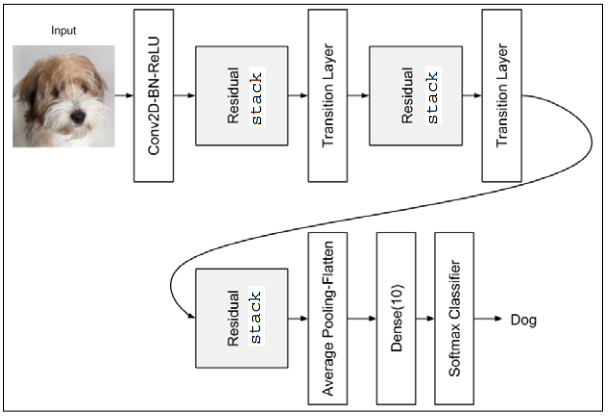

In [3]:
from IPython.display import Image
Image(filename="ResNetArchitecture.PNG")

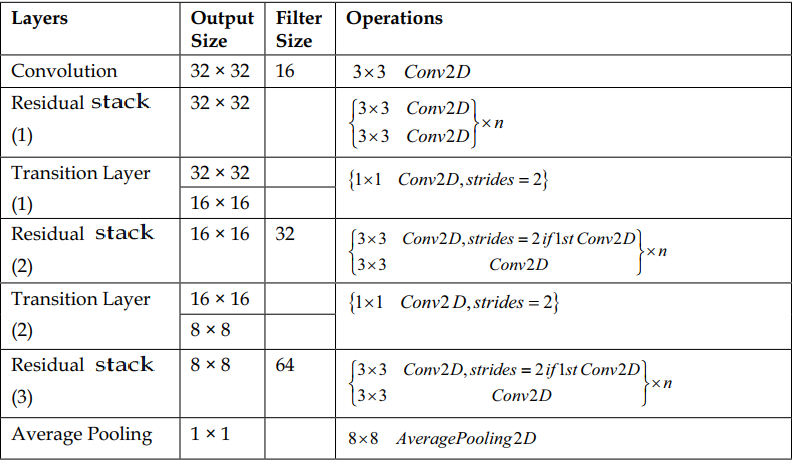

In [4]:
Image(filename="ResNetConfiguration.PNG")

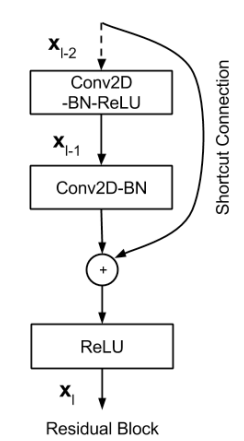

In [ ]:
Image(filename="ResidualBlock.PNG")

In [5]:
import numpy as np

from keras.datasets import cifar10
from keras.utils import to_categorical, plot_model
from keras.layers import Conv2D, Input, Flatten, Dense, Activation, BatchNormalization
from keras.layers import add, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

Using TensorFlow backend.


In [8]:
# Preprocessing

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

pixel_mean = np.mean(x_train, axis=0)

x_train = x_train - pixel_mean
x_test = x_test - pixel_mean

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_train shape:', x_test.shape)
print('y_train shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 10)


In [ ]:
n_classes = 10
n = 3
n_stacks = 3
filters = [16, 32, 64]
m_train = x_train.shape[0]

batch_size = 32
epochs = 200

In [ ]:
def resnet_layer(inputs,
                 filters,
                 strides=1,
                 kernel_size=3,
                 activation='relu',
                 batch_normalization=True):
    
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4)
              )(inputs)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation('relu')(x)
    
    return x 
    

In [20]:
inputs = Input(shape=(32, 32, 3) , name = 'inputs')
x = inputs
x = resnet_layer(inputs= x,
                 filters=16)
print('conv_1:', x.shape)

for stack in range(n_stacks):
    for block in range(n):
        if stack !=0 and block == 0:
            strides = 2
        else:
            strides = 1
        y = resnet_layer(inputs=x,
                         filters=filters[stack],
                         strides=strides)
        y = resnet_layer(inputs=y,
                         filters=filters[stack],
                         activation=None,
                        strides=1)
        if stack !=0 and block == 0:
            x = resnet_layer(inputs=x,
                            filters=filters[stack],
                            kernel_size=1,
                            strides=2,
                            activation=None,
                            batch_normalization=False)
        x = add([x, y])
        x = Activation('relu')(x)
x = AveragePooling2D(8)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax',kernel_initializer='he_normal')(x)

conv_1: (?, 32, 32, 16)


W0821 14:57:52.533811 140368902412160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [21]:
model = Model(inputs, outputs, name='resnet_v1_20')
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])
model.summary()
plot_model(model, 'resnet_v1_20.png', show_shapes=True)

W0821 15:06:49.686794 140368902412160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 16)   448         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 32, 32, 16)   64          conv2d_63[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 32, 32, 16)   0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
conv2d_64 

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


check_point = ModelCheckpoint(filepath='resnet_v1_20.h5',
                              monitor='val_acc',
                              save_best_only=True,
                              verbose=1)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=5,
                               factor=np.sqrt(0.1),
                               cooldown=0,
                               verbose=1,
                               mean_lr=0.5e-6)

In [ ]:
data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
data_generator.fit(x_train)

In [ ]:
model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=m_train//batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[check_point, lr_scheduler, lr_reducer])

Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1562/1562 [==============================] - 107s 69ms/step - loss: 1.6070 - acc: 0.4727 - val_loss: 2.2586 - val_acc: 0.3663

Epoch 00001: val_acc improved from -inf to 0.36630, saving model to resnet_v1_20.h5
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1562/1562 [==============================] - 101s 65ms/step - loss: 1.2015 - acc: 0.6292 - val_loss: 1.6095 - val_acc: 0.5308

Epoch 00002: val_acc improved from 0.36630 to 0.53080, saving model to resnet_v1_20.h5
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1562/1562 [==============================] - 99s 63ms/step - loss: 1.0364 - acc: 0.6913 - val_loss: 1.3891 - val_acc: 0.5714

Epoch 00003: val_acc improved from 0.53080 to 0.57140, saving model to resnet_v1_20.h5
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1562/1562 [==============================]